## <font color='#90c149'>Imports</font>

In [2]:
#Native imports
import os

In [3]:
#Library imports
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2

## <font color='#90c149'>Setup</font>
We use images from the flair dataset. They are in TIF format and are composed of 5 channels.
- R
- G
- B
- NIR
- Elevation

In [4]:
# The relative path of the image being treated
tif_path = "../flair/dataflair/flair_1_toy_aerial_train/D031_2019/Z8_UU/img/IMG_020484.tif"


# <font color='#90c149'>Processing</font>

## <font color='#90c149'>Image Display</font>
First, we display the five channels of the image

In [5]:
from data import read_tif_image
from display import display_5channel_image

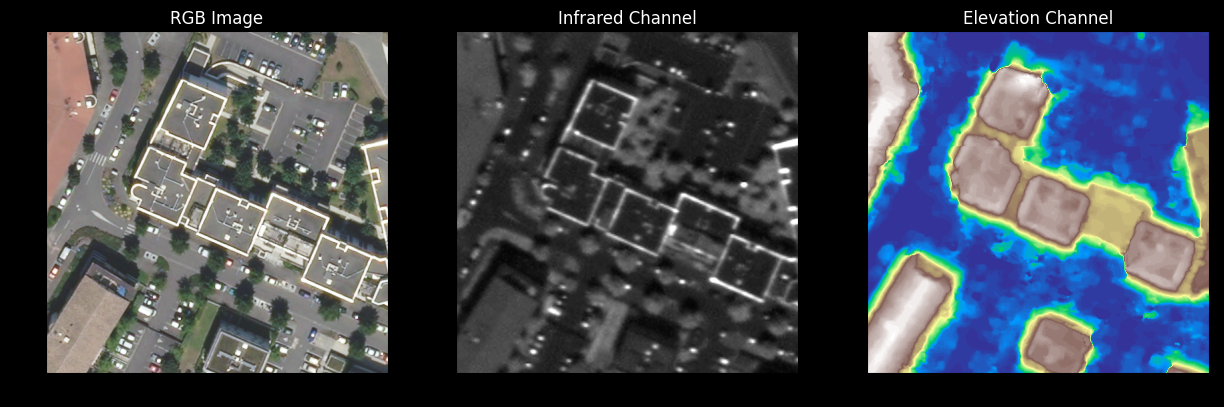

In [6]:
image=read_tif_image(tif_path)
display_5channel_image(image)

## <font color='#90c149'>NDVI Calculation and Display</font>
Then, we calculate the NDVI indice which reflects how likely a pixel is to represent vegetation in a picture. It is calculated like so :
$$NDVI = \frac{NIR - Red}{NIR + Red}$$

In [7]:
from display import display_NDVI_RGB

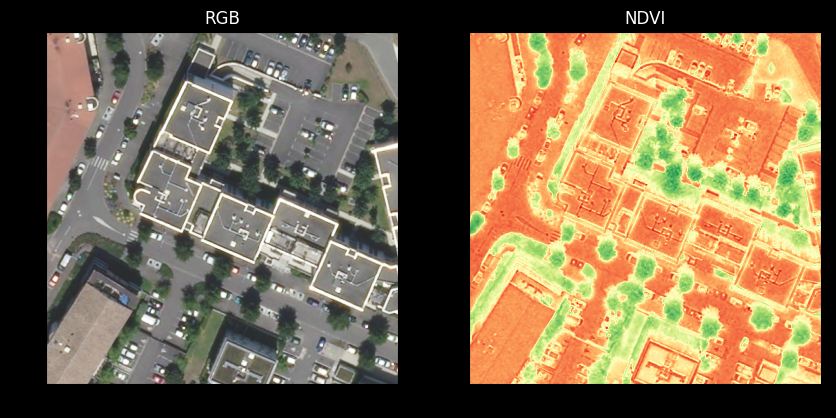

In [8]:
display_NDVI_RGB(image)

## <font color='#90c149'>Thresholds adjustement</font>
We want to remove the non-tree data of the image. In order to do so, we create a binary map from a threshold applied to the ndvi image.
$$binary(ndvi) = \begin{cases}
    1 & \text{if } ndvi>threshold \\
    0 & \text{otherwise}  \\
\end{cases}$$
We aim to set the threshold in order to see only the trees so that every tree is in a different related component in the image.

In [9]:
from processing import binary_threshold, NDVI 
from display import imshow
from ipywidgets import interact

In [10]:
image = read_tif_image(tif_path)
ndvi = NDVI(image)
@interact(minN=(-1, 1, 0.01), minE=(-1, 74, 1), maxE=(-1, 74, 1))
def threshold_and_blur(minN, minE, maxE):
    ndvi_thresholded = binary_threshold(ndvi, threshold_min=minN)
    elevation_thresholded = binary_threshold(image[:,:,4], threshold_min=minE, threshold_max=maxE)
    imshow(ndvi_thresholded, title="Only NDVI threshold")
    imshow(elevation_thresholded, title="Only elevation threshold")
    imshow(ndvi_thresholded*elevation_thresholded, title="Both thresholds")

interactive(children=(FloatSlider(value=0.0, description='minN', max=1.0, min=-1.0, step=0.01), IntSlider(valu…

We chose **minN = 0.2**, **minN = -1** and **minN = 20** and define the fonction **binary_map(image)** accordingly.

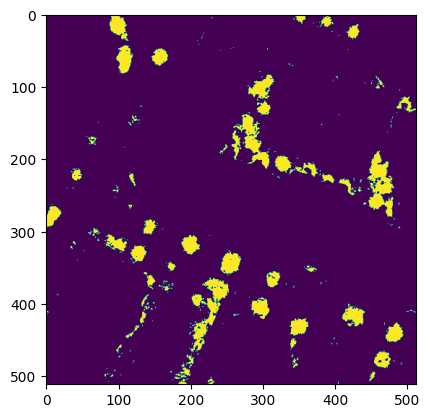

In [11]:
from processing import binary_map
imshow(binary_map(image))

We decide to keep a threshold of **0.22**

## <font color='#90c149'>Related components separation</font>
The aim is now to extract the related components of the image as they are likely to represent different groups of trees. In order to do so, we use the openCV library.

In [12]:
from processing import extract_connected_components, indice
from display import display_colorized_connected_components, display_colorized_connected_components_with_size_filtering

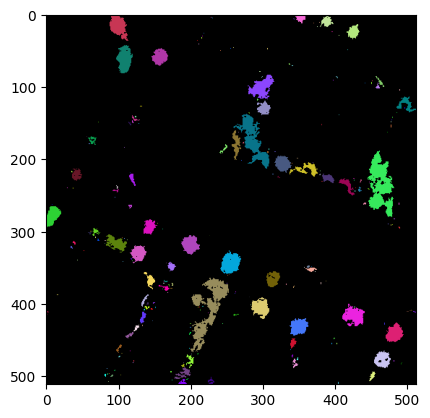

Number of connected components: 241


In [13]:
binary_image = binary_map(image)
display_colorized_connected_components(binary_image)

In [14]:
min_size = 50

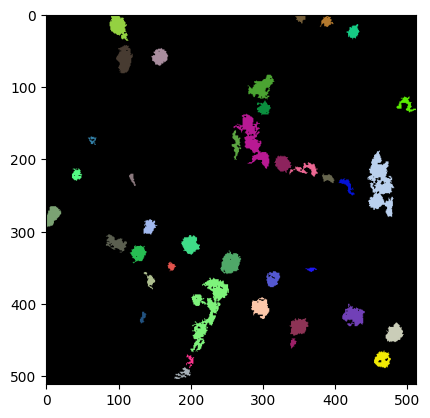

Number of connected components: 40


In [15]:
display_colorized_connected_components_with_size_filtering(binary_image, min_size=50)

## <font color='#90c149'>Highlighting the max of each component</font>
We now color the ndvi maximum of each connected component.

In [16]:
from processing import coords_max_ndvi_component
from display import display_result

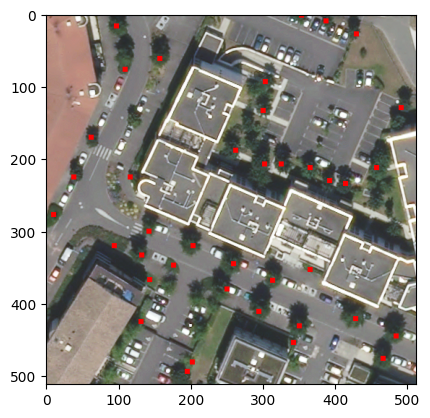

In [17]:
display_result(image, coords_of_maximums=coords_max_ndvi_component(image))

## <font color='#90c149'>Highlighting local maximums</font>
We now color the ndvi local maximums of each connexe components.

In [18]:
from processing import local_maximums_of_ndvi_connexe_components

In [22]:
@interact(local_max_size=(5, 300, 5), min_size=(0, 300, 5))
def display(local_max_size, min_size):
    display_result(image, coords_of_maximums=local_maximums_of_ndvi_connexe_components(image, min_size, local_max_size))

interactive(children=(IntSlider(value=150, description='local_max_size', max=300, min=5, step=5), IntSlider(va…